In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,LSTM
from keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from datetime import datetime
from matplotlib import pyplot

In [2]:
# Cargando el conjunto de Datos
df = pd.read_csv('Ocupacion-Uci.csv',  parse_dates=[0], header=None,index_col=0, squeeze=True,names=['Fecha','Camas UCI Ocupadas Covid-19'])
df.head()

Fecha
2020-08-04    106
2020-09-04    136
2020-10-04    150
2020-11-04    148
2020-12-04    178
Name: Camas UCI Ocupadas Covid-19, dtype: int64

## Preparación de los datos LSTM

In [3]:
PASOS=7

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,-1.000000,-0.971671,-0.958451,-0.960340,-0.932011,-0.955619,-0.966006,-0.951841
8,-0.971671,-0.958451,-0.960340,-0.932011,-0.955619,-0.966006,-0.951841,-0.958451
9,-0.958451,-0.960340,-0.932011,-0.955619,-0.966006,-0.951841,-0.958451,-0.977337
10,-0.960340,-0.932011,-0.955619,-0.966006,-0.951841,-0.958451,-0.977337,-0.970727
11,-0.932011,-0.955619,-0.966006,-0.951841,-0.958451,-0.977337,-0.970727,-0.969783


## Dividimos el conjunto de entrenamiento y validación

In [ ]:
# split into train and test sets
values = reframed.values
n_train_days = 369
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# remodelar la entrada para que sea 3D [muestras, intervalos de tiempo, características]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(369, 1, 7) (369,) (103, 1, 7) (103,)


In [ ]:
def crear_modeloLSTM():
    model = Sequential() 
    model.add(LSTM(7, return_sequences=True, input_shape=(1,PASOS),activation='tanh'))
    model.add(LSTM(5, return_sequences=True, activation='tanh',kernel_regularizer=l2(0.05), recurrent_regularizer=l2(0.05), bias_regularizer=l2(0.05)))
    model.add(LSTM(3, return_sequences=True, activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [ ]:
EPOCHS=60

model = crear_modeloLSTM()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 7)              420       
                                                                 
 lstm_4 (LSTM)               (None, 1, 5)              260       
                                                                 
 lstm_5 (LSTM)               (None, 1, 3)              108       
                                                                 
 flatten_1 (Flatten)         (None, 3)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 792
Trainable params: 792
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
53/53 [==============================] - 7s 2

## Visualización de Resultados

103


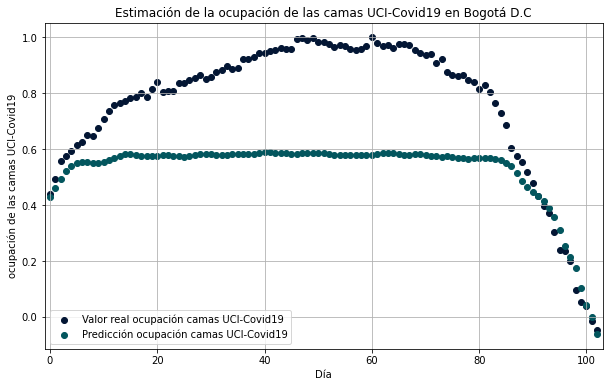

In [ ]:
results=model.predict(x_val)
print( len(results) )
plt.figure(figsize=(10,6))
plt.scatter(range(len(y_val)),y_val,color="#031634",label="Valor real ocupación camas UCI-Covid19")
plt.scatter(range(len(results)),results,color="#03565E",label="Predicción ocupación camas UCI-Covid19")
plt.title('Estimación de la ocupación de las camas UCI-Covid19 en Bogotá D.C')
plt.xlabel('Día')
plt.ylabel('ocupación de las camas UCI-Covid19')
plt.legend()
plt.xlim(-1,103)
plt.grid()
plt.show()

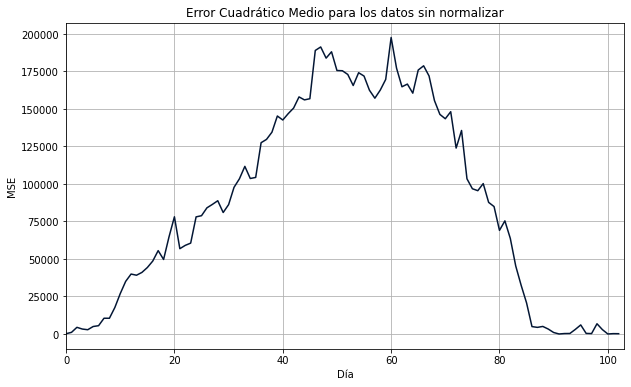

In [ ]:
n=len(results)
MSE=np.zeros(n)
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
MSEsum=0
for i in range(0,len(results)):
  MSE[i] = (compara2['real'][i] - compara2['prediccion'][i])**2
  MSEsum = np.sum(MSE)/n
plt.figure(figsize=(10,6))
plt.plot(range(len(results)),MSE, color="#031634")
plt.title('Error Cuadrático Medio para los datos sin normalizar')
plt.xlabel('Día')
plt.ylabel('MSE')
plt.xlim(0,103)
plt.grid()
plt.show()

In [ ]:
print('El MSE es de %0.3f' % MSEsum)

El MSE es de 86544.443


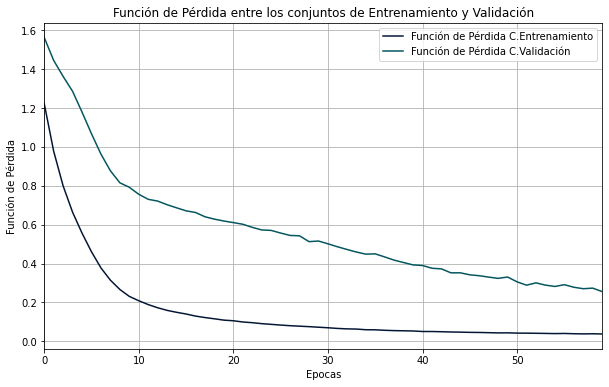

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], color="#031634",label="Función de Pérdida C.Entrenamiento")
plt.plot(history.history['val_loss'], color="#03565E" ,label="Función de Pérdida C.Validación")
plt.title('Función de Pérdida entre los conjuntos de Entrenamiento y Validación')
plt.xlabel('Epocas')
plt.ylabel('Función de Pérdida')
plt.legend()
plt.grid()
plt.xlim(0,59)
plt.show()

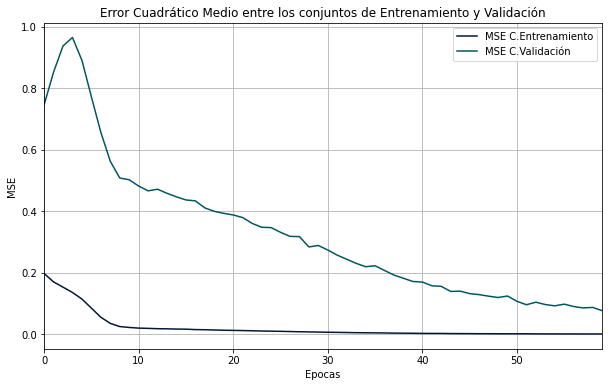

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['mse'], color="#031634", label="MSE C.Entrenamiento")
plt.plot(history.history['val_mse'], color="#03565E", label="MSE C.Validación")
plt.title('Error Cuadrático Medio entre los conjuntos de Entrenamiento y Validación')
plt.ylabel('MSE')
plt.xlabel('Epocas')
plt.legend()
plt.grid()
plt.xlim(0,59)
plt.show()

In [ ]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(10)

,real,prediccion,diferencia
0,1632.0,1618.368530,13.631470
1,1687.0,1654.198975,32.801025
2,1754.0,1687.391479,66.608521
3,1776.0,1718.659912,57.340088
4,1792.0,1738.747192,53.252808
5,1818.0,1747.460571,70.539429
6,1828.0,1753.649536,74.350464
7,1854.0,1751.598389,102.401611
8,1852.0,1749.625244,102.374756
9,1881.0,1748.240601,132.759399


In [ ]:
compara2.describe()

,real,prediccion,diferencia
count,103.000000,103.000000,103.000000
mean,1973.281494,1722.703979,250.577560
std,268.451385,136.140076,154.881271
min,1114.000000,1100.339844,-82.510864
25%,1867.500000,1750.835388,117.580505
50%,2063.000000,1776.070068,291.436035
75%,2175.000000,1781.801636,391.252197
max,2224.000000,1788.771851,444.586426


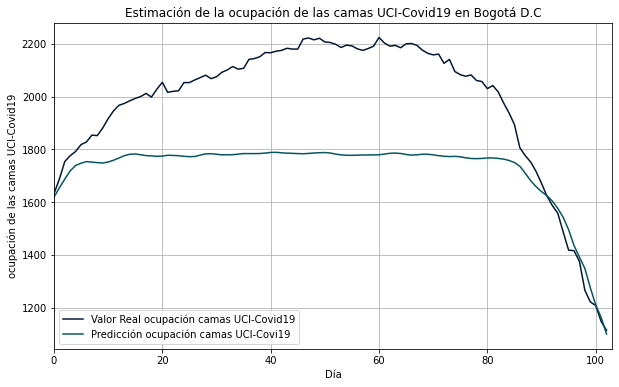

In [ ]:
plt.figure(figsize=(10,6))
compara2['real'].plot(color="#031634",label="Valor Real ocupación camas UCI-Covid19")
compara2['prediccion'].plot( color="#03565E",label="Predicción ocupación camas UCI-Covi19")
plt.title('Estimación de la ocupación de las camas UCI-Covid19 en Bogotá D.C')
plt.xlabel('Día')
plt.ylabel('ocupación de las camas UCI-Covid19')
plt.legend()
plt.xlim(0,103)
plt.grid()
plt.show()

## PRONOSTICO
A partir de los últimos tres meses del 2021, intentaremos predecir el mes de Agosto.

In [ ]:
ultimosDias = df['2021-07-01':'2021-07-31']
ultimosDias

Fecha
2021-07-01    1539
2021-07-02    1382
2021-07-03     874
2021-07-04    1051
2021-07-05    2012
2021-07-06    2215
2021-07-07    2061
2021-07-13    1938
2021-07-14    1894
2021-07-15    1806
2021-07-16    1776
2021-07-17    1752
2021-07-18    1716
2021-07-19    1671
2021-07-20    1623
2021-07-21    1587
2021-07-22    1558
2021-07-23    1487
2021-07-24    1418
2021-07-25    1416
2021-07-26    1375
2021-07-27    1266
2021-07-28    1222
2021-07-29    1208
2021-07-30    1148
2021-07-31    1114
Name: Camas UCI Ocupadas Covid-19, dtype: int64

## Preparamos los datos para Test

In [ ]:
values = ultimosDias.values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,-0.008203,-0.242357,-1.000000,-0.736018,0.697241,1.000000,0.770320
8,-0.242357,-1.000000,-0.736018,0.697241,1.000000,0.770320,0.586875
9,-1.000000,-0.736018,0.697241,1.000000,0.770320,0.586875,0.521253
10,-0.736018,0.697241,1.000000,0.770320,0.586875,0.521253,0.390007
11,0.697241,1.000000,0.770320,0.586875,0.521253,0.390007,0.345265
12,1.000000,0.770320,0.586875,0.521253,0.390007,0.345265,0.309470
13,0.770320,0.586875,0.521253,0.390007,0.345265,0.309470,0.255779


In [ ]:
values = reframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
x_test

(13, 1, 7)


array([[[ 0.7703204 ,  0.5868752 ,  0.52125263,  0.39000726,
          0.34526467,  0.30947042,  0.25577903]],

       [[ 0.5868752 ,  0.52125263,  0.39000726,  0.34526467,
          0.30947042,  0.25577903,  0.18866491]],

       [[ 0.52125263,  0.39000726,  0.34526467,  0.30947042,
          0.25577903,  0.18866491,  0.11707664]],

       [[ 0.39000726,  0.34526467,  0.30947042,  0.25577903,
          0.18866491,  0.11707664,  0.06338549]],

       [[ 0.34526467,  0.30947042,  0.25577903,  0.18866491,
          0.11707664,  0.06338549,  0.02013397]],

       [[ 0.30947042,  0.25577903,  0.18866491,  0.11707664,
          0.06338549,  0.02013397, -0.08575702]],

       [[ 0.25577903,  0.18866491,  0.11707664,  0.06338549,
          0.02013397, -0.08575702, -0.18866539]],

       [[ 0.18866491,  0.11707664,  0.06338549,  0.02013397,
         -0.08575702, -0.18866539, -0.19164824]],

       [[ 0.11707664,  0.06338549,  0.02013397, -0.08575702,
         -0.18866539, -0.19164824, -0.25279

In [ ]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

## Pronóstico para el próximo mes

In [ ]:
results=[]
for i in range(31):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

[[[ 0.7703204   0.5868752   0.52125263  0.39000726  0.34526467
    0.30947042  0.25577903]]

 [[ 0.5868752   0.52125263  0.39000726  0.34526467  0.30947042
    0.25577903  0.18866491]]

 [[ 0.52125263  0.39000726  0.34526467  0.30947042  0.25577903
    0.18866491  0.11707664]]

 [[ 0.39000726  0.34526467  0.30947042  0.25577903  0.18866491
    0.11707664  0.06338549]]

 [[ 0.34526467  0.30947042  0.25577903  0.18866491  0.11707664
    0.06338549  0.02013397]]

 [[ 0.30947042  0.25577903  0.18866491  0.11707664  0.06338549
    0.02013397 -0.08575702]]

 [[ 0.25577903  0.18866491  0.11707664  0.06338549  0.02013397
   -0.08575702 -0.18866539]]

 [[ 0.18866491  0.11707664  0.06338549  0.02013397 -0.08575702
   -0.18866539 -0.19164824]]

 [[ 0.11707664  0.06338549  0.02013397 -0.08575702 -0.18866539
   -0.19164824 -0.25279665]]

 [[ 0.06338549  0.02013397 -0.08575702 -0.18866539 -0.19164824
   -0.25279665 -0.41536176]]

 [[ 0.02013397 -0.08575702 -0.18866539 -0.19164824 -0.25279665
   -0.4

In [ ]:
# Re-Convertimos los resultados
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([0.184837], dtype=float32), array([0.15757804], dtype=float32), array([0.12222323], dtype=float32), array([0.09007645], dtype=float32), array([0.05108728], dtype=float32), array([0.02143398], dtype=float32), array([-0.00338778], dtype=float32), array([-0.02822365], dtype=float32), array([-0.05582063], dtype=float32), array([-0.07957896], dtype=float32), array([-0.10097874], dtype=float32), array([-0.12159507], dtype=float32), array([-0.14315534], dtype=float32), array([-0.16385813], dtype=float32), array([-0.1832983], dtype=float32), array([-0.20251428], dtype=float32), array([-0.22246079], dtype=float32), array([-0.24275157], dtype=float32), array([-0.26320714], dtype=float32), array([-0.2843362], dtype=float32), array([-0.30681947], dtype=float32), array([-0.33082134], dtype=float32), array([-0.3564185], dtype=float32), array([-0.38399464], dtype=float32), array([-0.41404575], dtype=float32), array([-0.44683692], dtype=float32), array([-0.482451], dtype=float32), array([-0.520

array([[1668.43330804],
       [1650.15617337],
       [1626.45077411],
       [1604.89636153],
       [1578.75412156],
       [1558.87158375],
       [1542.22858886],
       [1525.57614101],
       [1507.0723653 ],
       [1491.14240506],
       [1476.79385152],
       [1462.97060182],
       [1448.51444275],
       [1434.63321895],
       [1421.59858193],
       [1408.71427295],
       [1395.34013398],
       [1381.73516765],
       [1368.01970832],
       [1353.85266544],
       [1338.77763966],
       [1322.68438778],
       [1305.52149492],
       [1287.03168695],
       [1266.8824158 ],
       [1244.89593753],
       [1221.01670089],
       [1195.20985647],
       [1167.52560022],
       [1138.23851108],
       [1107.8738879 ]])

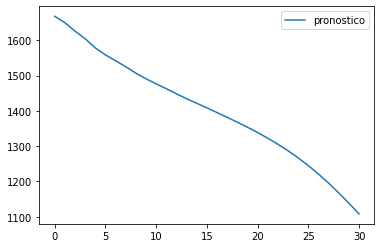

In [ ]:
prediccionAgostoUCI = pd.DataFrame(inverted)
prediccionAgostoUCI.columns = ['pronostico']
prediccionAgostoUCI.plot()
prediccionAgostoUCI.to_csv('pronostico-Uci-Regularización l2.csv')